# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook.  This is notebook:
1. Get probe template
2. Get the Bragg disks
3. Calibrate
4. Calculate lattice vectors
5. Fit lattice vectors
6. Calculate strain
7. **Visualize strain maps**

# Notebook 7: Visualize strain maps

In this step the strain maps are visualized.

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import medfilt

from py4DSTEM.file.datastructure import DataCube, DiffractionSlice, RealSlice, PointList, PointListArray
from py4DSTEM.file.readwrite import FileBrowser, read, append

In [2]:
# Examine file contents

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    braggvectormap_shiftcorrected_ellipsecorrectedDiffractionSlice    
   2    braggvectormap_uncorrected          DiffractionSlice    
   3    probe                               DiffractionSlice    
   4    diffraction_shifts                  RealSlice           
   5    strain_map                          RealSlice           
   6    uv_map                              RealSlice           
   7    lattice_vectors                     PointList           
   8    braggpeaks                          PointListArray      
   9    braggpeaks_shifted_ellipticalcorrectedPointListArray      


In [3]:
# Load data

strain_maps = browser.get_dataobject('strain_map')
uv_map = browser.get_dataobject('uv_map')
browser.close()

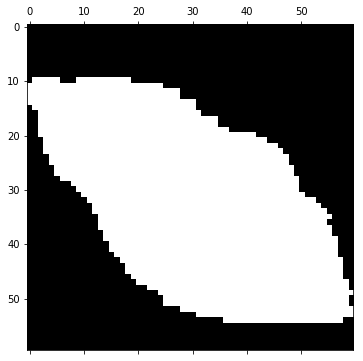

In [4]:
# Make a mask

mask = uv_map.data2D['mask'].astype(bool)

fig,ax = plt.subplots(figsize=(6,6))
ax.matshow(mask)
plt.show()

### Square layout

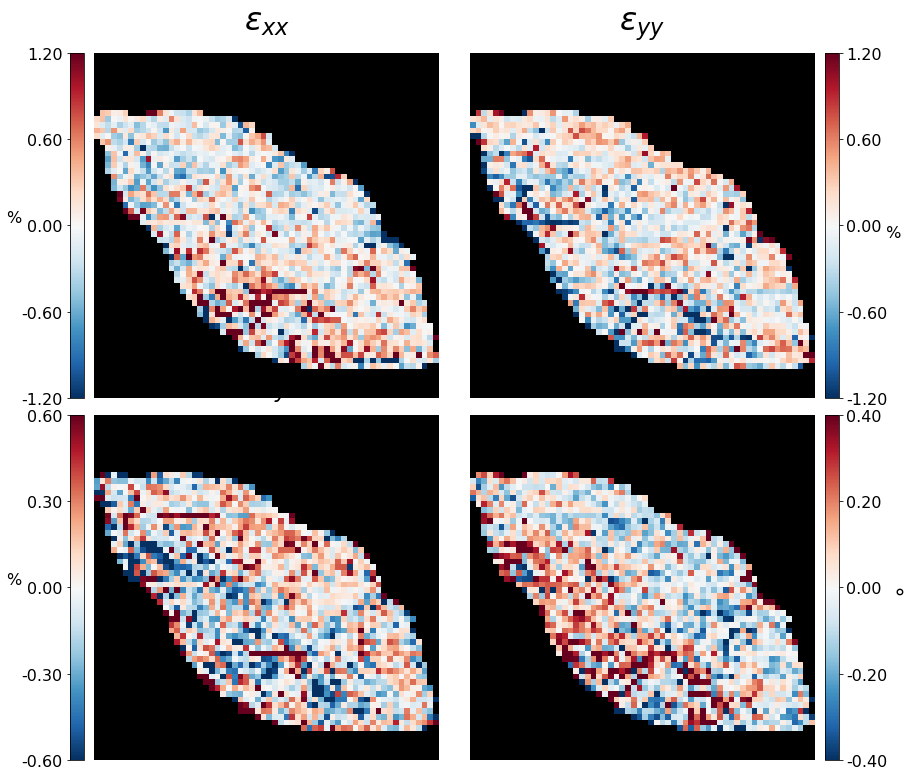

In [5]:
# Plot data
# Unfiltered
# Sqaure layout

titlesize=32
ticklabelsize=16

# Set colorscales
automate_colorscale = False
n_stds=3

e_xx_range = [-1.2,1.2] # In percentage
e_yy_range = [-1.2,1.2] # In percentage
e_xy_range = [-0.6,0.6] # In percentage
theta_range = [-.4,.4] # In degrees


# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_xx_ave, e_xx_std = np.average(strain_maps.data2D['e_xx'][mask]),np.std(strain_maps.data2D['e_xx'][mask])
e_yy_ave, e_yy_std = np.average(strain_maps.data2D['e_yy'][mask]),np.std(strain_maps.data2D['e_yy'][mask])
e_xy_ave, e_xy_std = np.average(strain_maps.data2D['e_xy'][mask]),np.std(strain_maps.data2D['e_xy'][mask])
theta_ave, theta_std = np.average(strain_maps.data2D['theta'][mask]),np.std(strain_maps.data2D['theta'][mask])

if automate_colorscale:
    e_xx_range = [-n_stds*e_xx_std*100,n_stds*e_xx_std*100]
    e_yy_range = [-n_stds*e_yy_std*100,n_stds*e_yy_std*100]
    e_xy_range = [-n_stds*e_xy_std*100,n_stds*e_xy_std*100]
    theta_range = [-n_stds*theta_std*180./np.pi,n_stds*theta_std*180/np.pi]

### Plot ###
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,
                                             figsize=(14,13),
                                             gridspec_kw={'wspace':0.05,'hspace':0.05})

cax11 = ax11.matshow(strain_maps.data2D['e_xx'],vmin=e_xx_range[0]/100., vmax=e_xx_range[1]/100., cmap="RdBu_r")
cax12 = ax12.matshow(strain_maps.data2D['e_yy'],vmin=e_yy_range[0]/100., vmax=e_yy_range[1]/100., cmap="RdBu_r")
cax21 = ax21.matshow(strain_maps.data2D['e_xy'],vmin=e_xy_range[0]/100., vmax=e_xy_range[1]/100., cmap="RdBu_r")
cax22 = ax22.matshow(strain_maps.data2D['theta'],vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

# Black overlay
ax11.matshow(plot_mask,cmap='gray')
ax12.matshow(plot_mask,cmap='gray')
ax21.matshow(plot_mask,cmap='gray')
ax22.matshow(plot_mask,cmap='gray')

# Colorbars
divider11 = make_axes_locatable(ax11)
divider12 = make_axes_locatable(ax12)
divider21 = make_axes_locatable(ax21)
divider22 = make_axes_locatable(ax22)
cbax11 = divider11.append_axes("left", size="4%", pad=0.15)
cbax12 = divider12.append_axes("right", size="4%", pad=0.15)
cbax21 = divider21.append_axes("left", size="4%", pad=0.15)
cbax22 = divider22.append_axes("right", size="4%", pad=0.15)

cb11 = plt.colorbar(cax11, cax=cbax11, ticks=np.linspace(e_xx_range[0]/100.,e_xx_range[1]/100.,5,endpoint=True))
cb12 = plt.colorbar(cax12, cax=cbax12, ticks=np.linspace(e_yy_range[0]/100.,e_yy_range[1]/100.,5,endpoint=True))
cb21 = plt.colorbar(cax21, cax=cbax21, ticks=np.linspace(e_xy_range[0]/100.,e_xy_range[1]/100.,5,endpoint=True))
cb22 = plt.colorbar(cax22, cax=cbax22, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True))

cb11.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xx_range[0],e_xx_range[1],5,endpoint=True)],size=ticklabelsize)
cb12.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_yy_range[0],e_yy_range[1],5,endpoint=True)],size=ticklabelsize)
cb21.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xy_range[0],e_xy_range[1],5,endpoint=True)],size=ticklabelsize)
cb22.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax11.yaxis.set_ticks_position('left')
cbax21.yaxis.set_ticks_position('left')

cbax11.set_ylabel("% ", size=ticklabelsize, rotation=0)
cbax12.set_ylabel(" %", size=ticklabelsize, rotation=0)
cbax21.set_ylabel("% ", size=ticklabelsize, rotation=0)
cbax22.set_ylabel(r" $^\circ$", size=2*ticklabelsize, rotation=0)

cbax11.yaxis.set_label_position('left')
cbax12.yaxis.set_label_position('right')
cbax21.yaxis.set_label_position('left')
cbax22.yaxis.set_label_position('right')


ax11.set_title(r'$\epsilon_{xx}$',size=titlesize)
ax12.set_title(r'$\epsilon_{yy}$',size=titlesize)
ax21.set_title(r'$\epsilon_{xy}$',size=titlesize)
ax22.set_title(r'$\theta$',size=titlesize)

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')

plt.show()

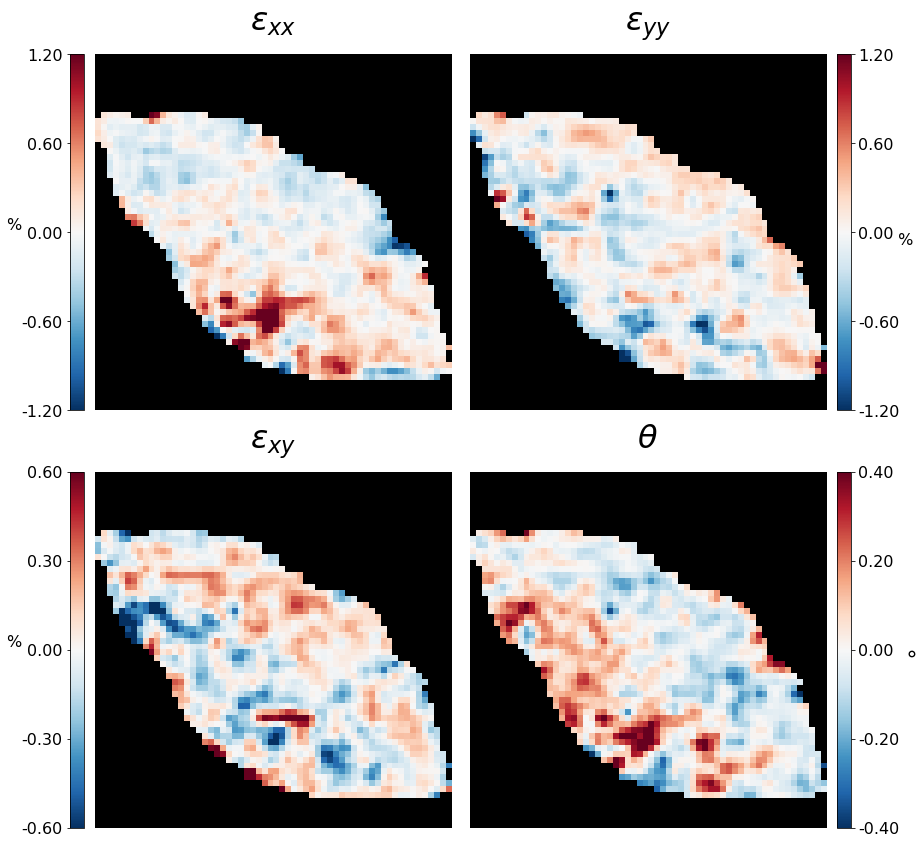

In [30]:
# Plot data
# Median filtering and gaussian smoothing
# Sqaure layout

sigma = .8
titlesize=32
ticklabelsize=16

# Set colorscales
automate_colorscale = False
n_stds=3

e_xx_range = [-1.2,1.2] # In percentage
e_yy_range = [-1.2,1.2] # In percentage
e_xy_range = [-0.6,0.6] # In percentage
theta_range = [-.4,.4] # In degrees



# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_xx_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_xx'], medfilt(np.where(mask,strain_maps.data2D['e_xx'],0),kernel_size=3)),sigma),0)
e_yy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_yy'], medfilt(np.where(mask,strain_maps.data2D['e_yy'],0),kernel_size=3)),sigma),0)
e_xy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_xy'], medfilt(np.where(mask,strain_maps.data2D['e_xy'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

e_xx_ave, e_xx_std = np.average(e_xx_smoothed[mask]),np.std(e_xx_smoothed[mask])
e_yy_ave, e_yy_std = np.average(e_yy_smoothed[mask]),np.std(e_yy_smoothed[mask])
e_xy_ave, e_xy_std = np.average(e_xy_smoothed[mask]),np.std(e_xy_smoothed[mask])
theta_ave, theta_std = np.average(theta_smoothed[mask]),np.std(theta_smoothed[mask])

if automate_colorscale:
    e_xx_range = [-n_stds*e_xx_std*100,n_stds*e_xx_std*100]
    e_yy_range = [-n_stds*e_yy_std*100,n_stds*e_yy_std*100]
    e_xy_range = [-n_stds*e_xy_std*100,n_stds*e_xy_std*100]
    theta_range = [-n_stds*theta_std*180./np.pi,n_stds*theta_std*180/np.pi]

### Plot ###
fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,
                                             figsize=(14,15),
                                             gridspec_kw={'wspace':0.05,'hspace':0.05})

cax11 = ax11.matshow(e_xx_smoothed,vmin=e_xx_range[0]/100., vmax=e_xx_range[1]/100., cmap="RdBu_r")
cax12 = ax12.matshow(e_yy_smoothed,vmin=e_yy_range[0]/100., vmax=e_yy_range[1]/100., cmap="RdBu_r")
cax21 = ax21.matshow(e_xy_smoothed,vmin=e_xy_range[0]/100., vmax=e_xy_range[1]/100., cmap="RdBu_r")
cax22 = ax22.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

# Black overlay
ax11.matshow(plot_mask,cmap='gray')
ax12.matshow(plot_mask,cmap='gray')
ax21.matshow(plot_mask,cmap='gray')
ax22.matshow(plot_mask,cmap='gray')

# Colorbars
divider11 = make_axes_locatable(ax11)
divider12 = make_axes_locatable(ax12)
divider21 = make_axes_locatable(ax21)
divider22 = make_axes_locatable(ax22)
cbax11 = divider11.append_axes("left", size="4%", pad=0.15)
cbax12 = divider12.append_axes("right", size="4%", pad=0.15)
cbax21 = divider21.append_axes("left", size="4%", pad=0.15)
cbax22 = divider22.append_axes("right", size="4%", pad=0.15)

cb11 = plt.colorbar(cax11, cax=cbax11, ticks=np.linspace(e_xx_range[0]/100.,e_xx_range[1]/100.,5,endpoint=True))
cb12 = plt.colorbar(cax12, cax=cbax12, ticks=np.linspace(e_yy_range[0]/100.,e_yy_range[1]/100.,5,endpoint=True))
cb21 = plt.colorbar(cax21, cax=cbax21, ticks=np.linspace(e_xy_range[0]/100.,e_xy_range[1]/100.,5,endpoint=True))
cb22 = plt.colorbar(cax22, cax=cbax22, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True))

cb11.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xx_range[0],e_xx_range[1],5,endpoint=True)],size=ticklabelsize)
cb12.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_yy_range[0],e_yy_range[1],5,endpoint=True)],size=ticklabelsize)
cb21.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xy_range[0],e_xy_range[1],5,endpoint=True)],size=ticklabelsize)
cb22.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax11.yaxis.set_ticks_position('left')
cbax21.yaxis.set_ticks_position('left')

cbax11.set_ylabel("% ", size=ticklabelsize, rotation=0)
cbax12.set_ylabel(" %", size=ticklabelsize, rotation=0)
cbax21.set_ylabel("% ", size=ticklabelsize, rotation=0)
cbax22.set_ylabel(r" $^\circ$", size=2*ticklabelsize, rotation=0)

cbax11.yaxis.set_label_position('left')
cbax12.yaxis.set_label_position('right')
cbax21.yaxis.set_label_position('left')
cbax22.yaxis.set_label_position('right')


ax11.set_title(r'$\epsilon_{xx}$',size=titlesize)
ax12.set_title(r'$\epsilon_{yy}$',size=titlesize)
ax21.set_title(r'$\epsilon_{xy}$',size=titlesize)
ax22.set_title(r'$\theta$',size=titlesize)

ax11.axis('off')
ax12.axis('off')
ax21.axis('off')
ax22.axis('off')

plt.show()

### Horizontal layout

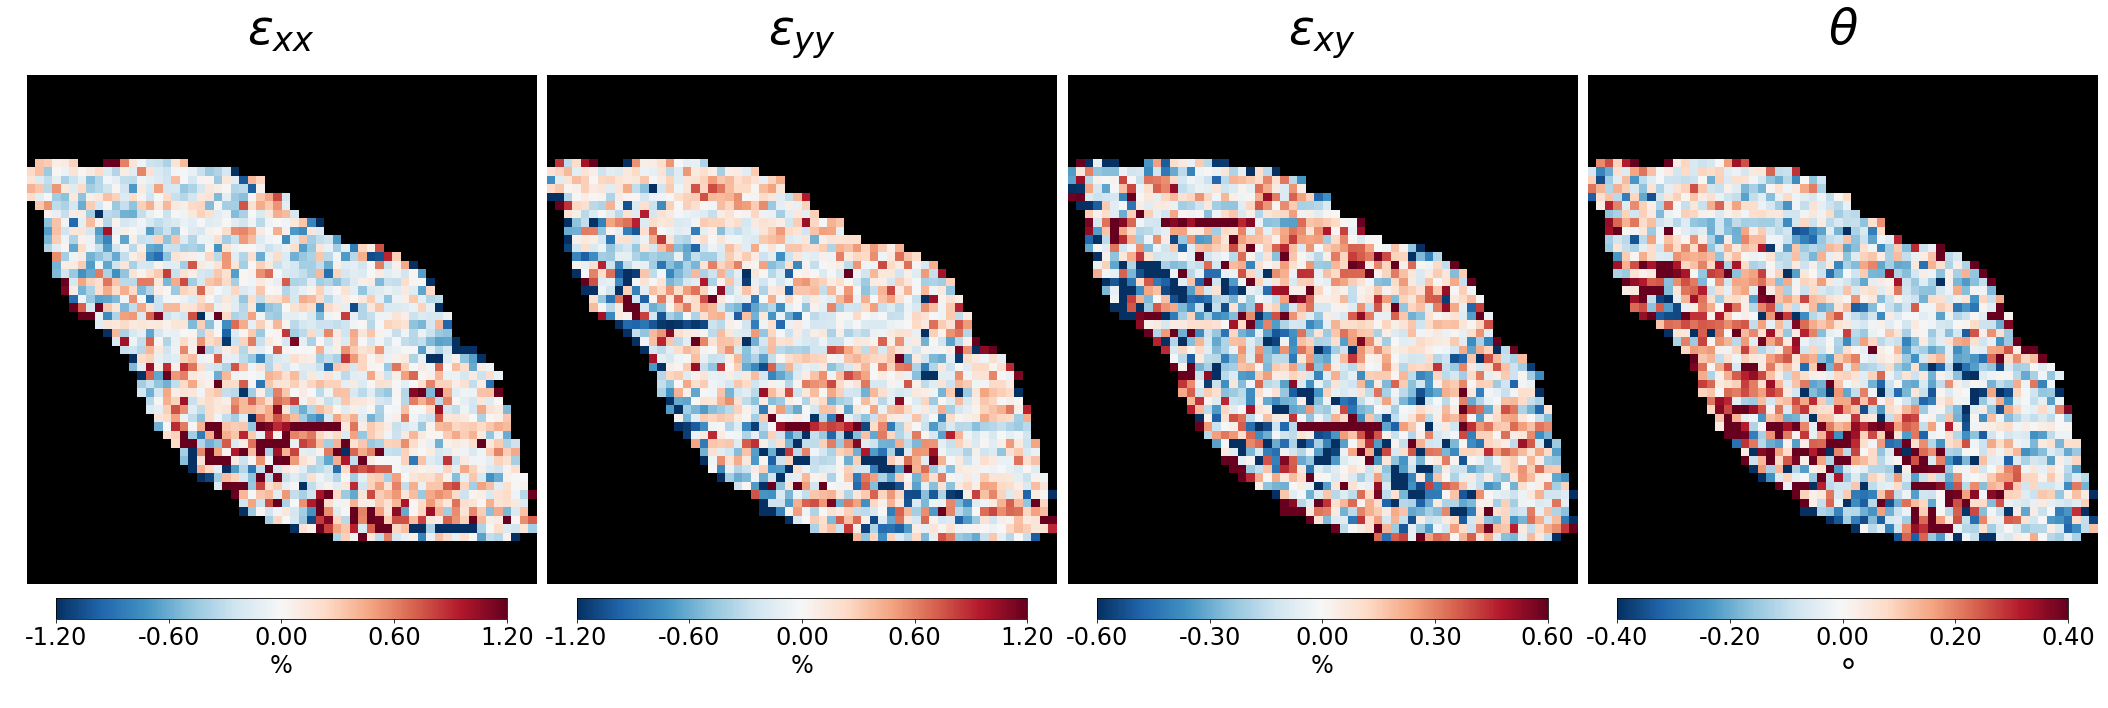

In [31]:
# Plot data
# Unfiltered
# Horizontal layout

sigma = .8
titlesize=48
ticklabelsize=24

# Set colorscales
automate_colorscale = False
n_stds=3

e_xx_range = [-1.2,1.2] # In percentage
e_yy_range = [-1.2,1.2] # In percentage
e_xy_range = [-0.6,0.6] # In percentage
theta_range = [-.4,.4] # In degrees



# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_xx_ave, e_xx_std = np.average(strain_maps.data2D['e_xx'][mask]),np.std(strain_maps.data2D['e_xx'][mask])
e_yy_ave, e_yy_std = np.average(strain_maps.data2D['e_yy'][mask]),np.std(strain_maps.data2D['e_yy'][mask])
e_xy_ave, e_xy_std = np.average(strain_maps.data2D['e_xy'][mask]),np.std(strain_maps.data2D['e_xy'][mask])
theta_ave, theta_std = np.average(strain_maps.data2D['theta'][mask]),np.std(strain_maps.data2D['theta'][mask])

if automate_colorscale:
    e_xx_range = [-n_stds*e_xx_std*100,n_stds*e_xx_std*100]
    e_yy_range = [-n_stds*e_yy_std*100,n_stds*e_yy_std*100]
    e_xy_range = [-n_stds*e_xy_std*100,n_stds*e_xy_std*100]
    theta_range = [-n_stds*theta_std*180./np.pi,n_stds*theta_std*180/np.pi]


    
### Plot ###
fig = plt.figure(figsize=(32,10))
           
gs = gridspec.GridSpec(2, 12, width_ratios=[1,20,1,1,20,1,1,20,1,1,20,1], height_ratios=[24, 1])
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.05)
ax1 = plt.subplot(gs[0,0:3])
ax2 = plt.subplot(gs[0,3:6])
ax3 = plt.subplot(gs[0,6:9,])
ax4 = plt.subplot(gs[0,9:12])

cbax1 = plt.subplot(gs[1,1])
cbax2 = plt.subplot(gs[1,4])
cbax3 = plt.subplot(gs[1,7,])
cbax4 = plt.subplot(gs[1,10])
    
cax1 = ax1.matshow(strain_maps.data2D['e_xx'],vmin=e_xx_range[0]/100., vmax=e_xx_range[1]/100., cmap="RdBu_r")
cax2 = ax2.matshow(strain_maps.data2D['e_yy'],vmin=e_yy_range[0]/100., vmax=e_yy_range[1]/100., cmap="RdBu_r")
cax3 = ax3.matshow(strain_maps.data2D['e_xy'],vmin=e_xy_range[0]/100., vmax=e_xy_range[1]/100., cmap="RdBu_r")
cax4 = ax4.matshow(strain_maps.data2D['theta'],vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

# Black overlay
ax1.matshow(plot_mask,cmap='gray')
ax2.matshow(plot_mask,cmap='gray')
ax3.matshow(plot_mask,cmap='gray')
ax4.matshow(plot_mask,cmap='gray')
    
# Colorbars

cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_xx_range[0]/100.,e_xx_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb2 = plt.colorbar(cax2, cax=cbax2, ticks=np.linspace(e_yy_range[0]/100.,e_yy_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb3 = plt.colorbar(cax3, cax=cbax3, ticks=np.linspace(e_xy_range[0]/100.,e_xy_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True), orientation='horizontal')

cb1.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xx_range[0],e_xx_range[1],5,endpoint=True)],size=ticklabelsize)
cb2.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_yy_range[0],e_yy_range[1],5,endpoint=True)],size=ticklabelsize)
cb3.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xy_range[0],e_xy_range[1],5,endpoint=True)],size=ticklabelsize)
cb4.ax.set_xticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax1.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax2.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax3.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax4.set_xlabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

ax1.set_title(r'$\epsilon_{xx}$',size=titlesize)
ax2.set_title(r'$\epsilon_{yy}$',size=titlesize)
ax3.set_title(r'$\epsilon_{xy}$',size=titlesize)
ax4.set_title(r'$\theta$',size=titlesize)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.show()

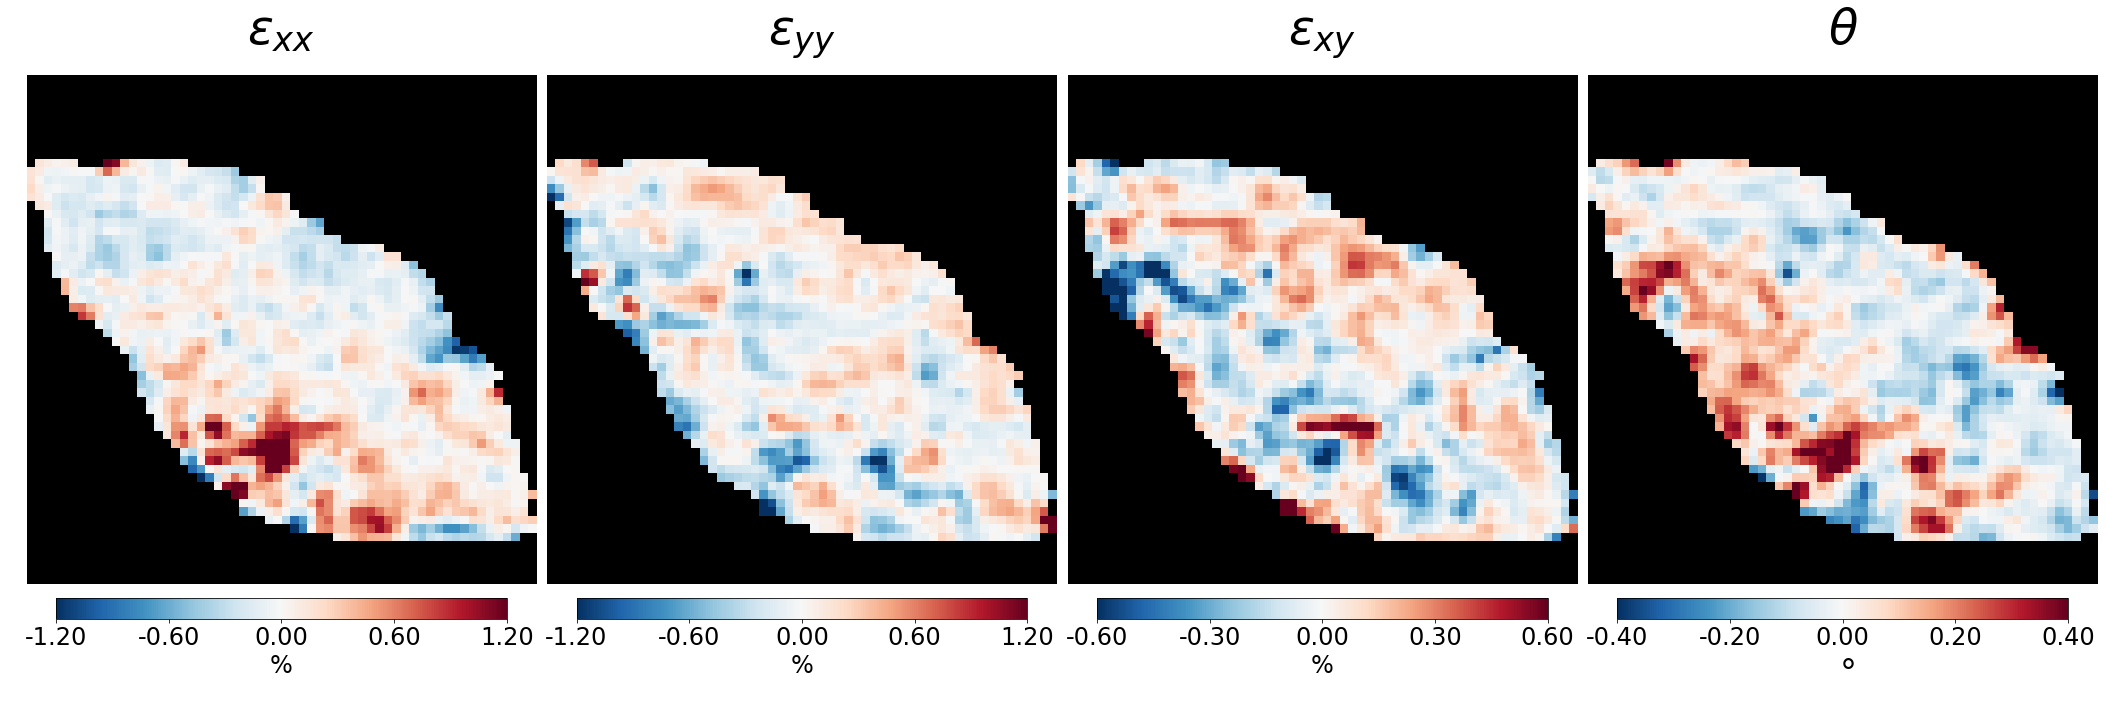

In [32]:
# Plot data
# Median filtering and gaussian smoothing
# Horizontal layout

sigma = .8
titlesize=48
ticklabelsize=24

# Set colorscales
automate_colorscale = False
n_stds=3

e_xx_range = [-1.2,1.2] # In percentage
e_yy_range = [-1.2,1.2] # In percentage
e_xy_range = [-0.6,0.6] # In percentage
theta_range = [-.4,.4] # In degrees



# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_xx_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_xx'], medfilt(np.where(mask,strain_maps.data2D['e_xx'],0),kernel_size=3)),sigma),0)
e_yy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_yy'], medfilt(np.where(mask,strain_maps.data2D['e_yy'],0),kernel_size=3)),sigma),0)
e_xy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_xy'], medfilt(np.where(mask,strain_maps.data2D['e_xy'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

e_xx_ave, e_xx_std = np.average(e_xx_smoothed[mask]),np.std(e_xx_smoothed[mask])
e_yy_ave, e_yy_std = np.average(e_yy_smoothed[mask]),np.std(e_yy_smoothed[mask])
e_xy_ave, e_xy_std = np.average(e_xy_smoothed[mask]),np.std(e_xy_smoothed[mask])
theta_ave, theta_std = np.average(theta_smoothed[mask]),np.std(theta_smoothed[mask])

if automate_colorscale:
    e_xx_range = [-n_stds*e_xx_std*100,n_stds*e_xx_std*100]
    e_yy_range = [-n_stds*e_yy_std*100,n_stds*e_yy_std*100]
    e_xy_range = [-n_stds*e_xy_std*100,n_stds*e_xy_std*100]
    theta_range = [-n_stds*theta_std*180./np.pi,n_stds*theta_std*180/np.pi]


    
### Plot ###
fig = plt.figure(figsize=(32,10))
           
gs = gridspec.GridSpec(2, 12, width_ratios=[1,20,1,1,20,1,1,20,1,1,20,1], height_ratios=[24, 1])
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.05)
ax1 = plt.subplot(gs[0,0:3])
ax2 = plt.subplot(gs[0,3:6])
ax3 = plt.subplot(gs[0,6:9,])
ax4 = plt.subplot(gs[0,9:12])

cbax1 = plt.subplot(gs[1,1])
cbax2 = plt.subplot(gs[1,4])
cbax3 = plt.subplot(gs[1,7,])
cbax4 = plt.subplot(gs[1,10])
    
cax1 = ax1.matshow(e_xx_smoothed,vmin=e_xx_range[0]/100., vmax=e_xx_range[1]/100., cmap="RdBu_r")
cax2 = ax2.matshow(e_yy_smoothed,vmin=e_yy_range[0]/100., vmax=e_yy_range[1]/100., cmap="RdBu_r")
cax3 = ax3.matshow(e_xy_smoothed,vmin=e_xy_range[0]/100., vmax=e_xy_range[1]/100., cmap="RdBu_r")
cax4 = ax4.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

# Black overlay
ax1.matshow(plot_mask,cmap='gray')
ax2.matshow(plot_mask,cmap='gray')
ax3.matshow(plot_mask,cmap='gray')
ax4.matshow(plot_mask,cmap='gray')
    
# Colorbars

cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_xx_range[0]/100.,e_xx_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb2 = plt.colorbar(cax2, cax=cbax2, ticks=np.linspace(e_yy_range[0]/100.,e_yy_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb3 = plt.colorbar(cax3, cax=cbax3, ticks=np.linspace(e_xy_range[0]/100.,e_xy_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True), orientation='horizontal')

cb1.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xx_range[0],e_xx_range[1],5,endpoint=True)],size=ticklabelsize)
cb2.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_yy_range[0],e_yy_range[1],5,endpoint=True)],size=ticklabelsize)
cb3.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_xy_range[0],e_xy_range[1],5,endpoint=True)],size=ticklabelsize)
cb4.ax.set_xticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax1.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax2.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax3.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax4.set_xlabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

ax1.set_title(r'$\epsilon_{xx}$',size=titlesize)
ax2.set_title(r'$\epsilon_{yy}$',size=titlesize)
ax3.set_title(r'$\epsilon_{xy}$',size=titlesize)
ax4.set_title(r'$\theta$',size=titlesize)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.show()

### Horizontal, share colorbar

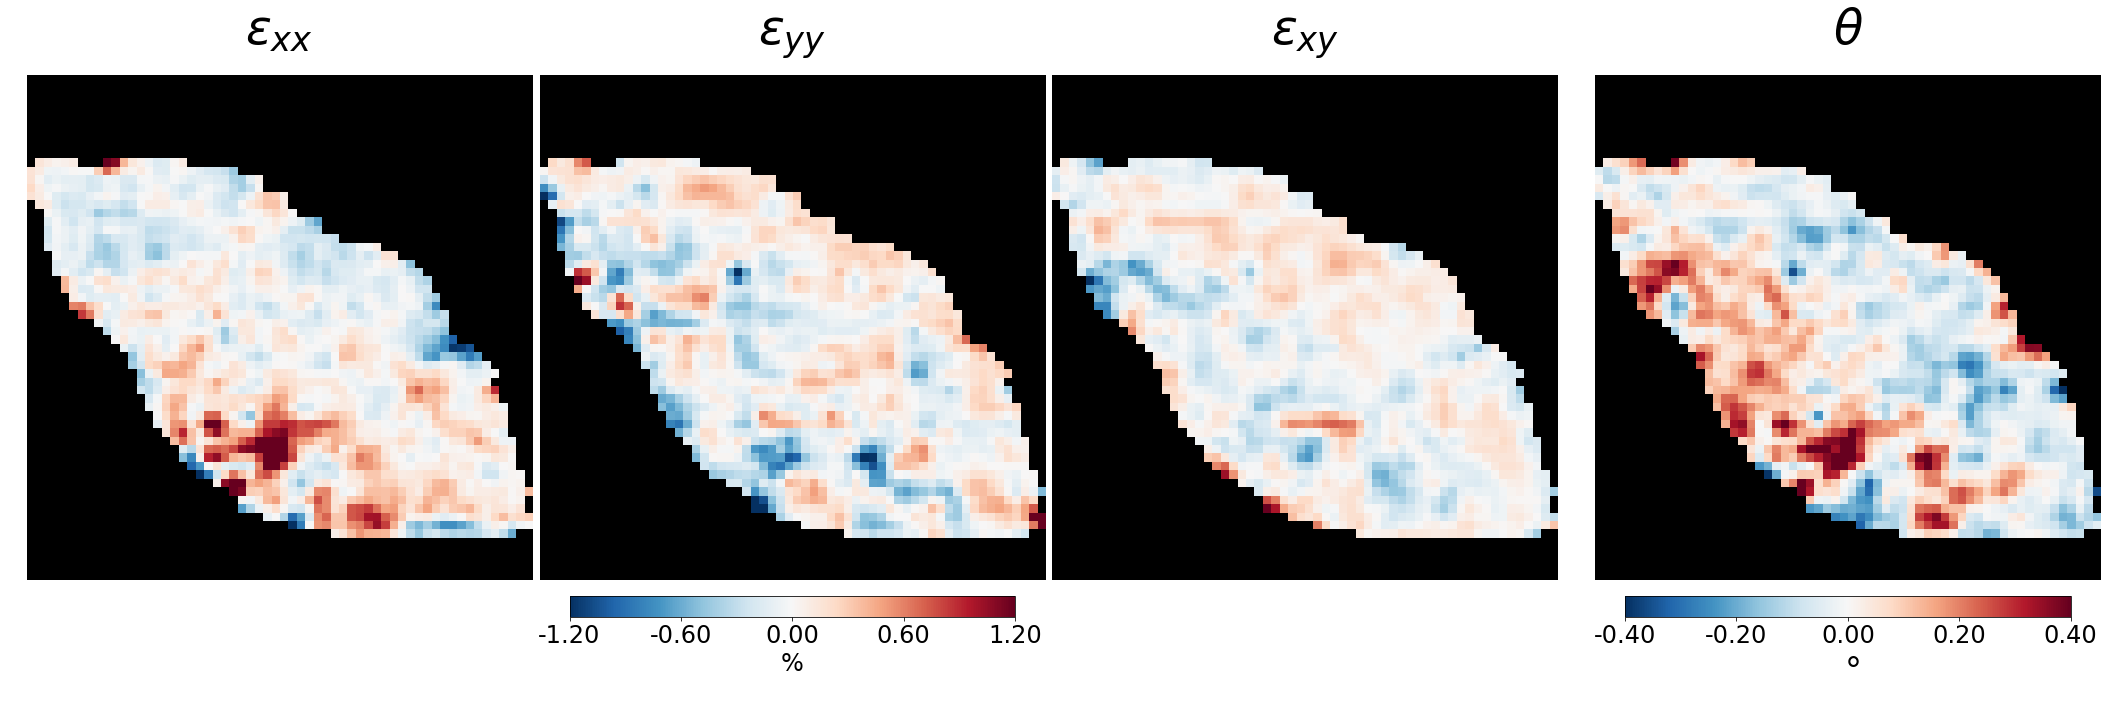

In [33]:
# Plot data
# Median filtering and gaussian smoothing
# Horizontal layout
# Shared colorbar, on bottom

sigma = .8
titlesize=48
ticklabelsize=24

e_range = [-1.2,1.2] # In percentage
theta_range = [-.4,.4] # In degrees


# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_xx_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_xx'], medfilt(np.where(mask,strain_maps.data2D['e_xx'],0),kernel_size=3)),sigma),0)
e_yy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_yy'], medfilt(np.where(mask,strain_maps.data2D['e_yy'],0),kernel_size=3)),sigma),0)
e_xy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_xy'], medfilt(np.where(mask,strain_maps.data2D['e_xy'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

e_xx_ave = np.average(e_xx_smoothed[mask])
e_yy_ave = np.average(e_yy_smoothed[mask])
e_xy_ave = np.average(e_xy_smoothed[mask])
theta_ave = np.average(theta_smoothed[mask])

    
### Plot ###
fig = plt.figure(figsize=(32,10))
           
gs = gridspec.GridSpec(2, 13, width_ratios=[1,20,1,1,20,1,1,20,1,1,1,20,1], height_ratios=[24, 1])
gs.update(left=0.05, right=0.95, wspace=0.05, hspace=0.05)
ax1 = plt.subplot(gs[0,0:3])
ax2 = plt.subplot(gs[0,3:6])
ax3 = plt.subplot(gs[0,6:9,])
ax4 = plt.subplot(gs[0,10:13])

cbax1 = plt.subplot(gs[1,1])
cbax2 = plt.subplot(gs[1,4])
cbax3 = plt.subplot(gs[1,7,])
cbax4 = plt.subplot(gs[1,11])
    
cax1 = ax1.matshow(e_xx_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
cax2 = ax2.matshow(e_yy_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
cax3 = ax3.matshow(e_xy_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
cax4 = ax4.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

# Black overlay
ax1.matshow(plot_mask,cmap='gray')
ax2.matshow(plot_mask,cmap='gray')
ax3.matshow(plot_mask,cmap='gray')
ax4.matshow(plot_mask,cmap='gray')
    
# Colorbars

cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb2 = plt.colorbar(cax2, cax=cbax2, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb3 = plt.colorbar(cax3, cax=cbax3, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,5,endpoint=True), orientation='horizontal')
cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True), orientation='horizontal')

cb1.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],5,endpoint=True)],size=ticklabelsize)
cb2.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],5,endpoint=True)],size=ticklabelsize)
cb3.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],5,endpoint=True)],size=ticklabelsize)
cb4.ax.set_xticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax1.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax2.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax3.set_xlabel("%", size=ticklabelsize, rotation=0)
cbax4.set_xlabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

cb1.remove()
cb3.remove()

ax1.set_title(r'$\epsilon_{xx}$',size=titlesize)
ax2.set_title(r'$\epsilon_{yy}$',size=titlesize)
ax3.set_title(r'$\epsilon_{xy}$',size=titlesize)
ax4.set_title(r'$\theta$',size=titlesize)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.show()

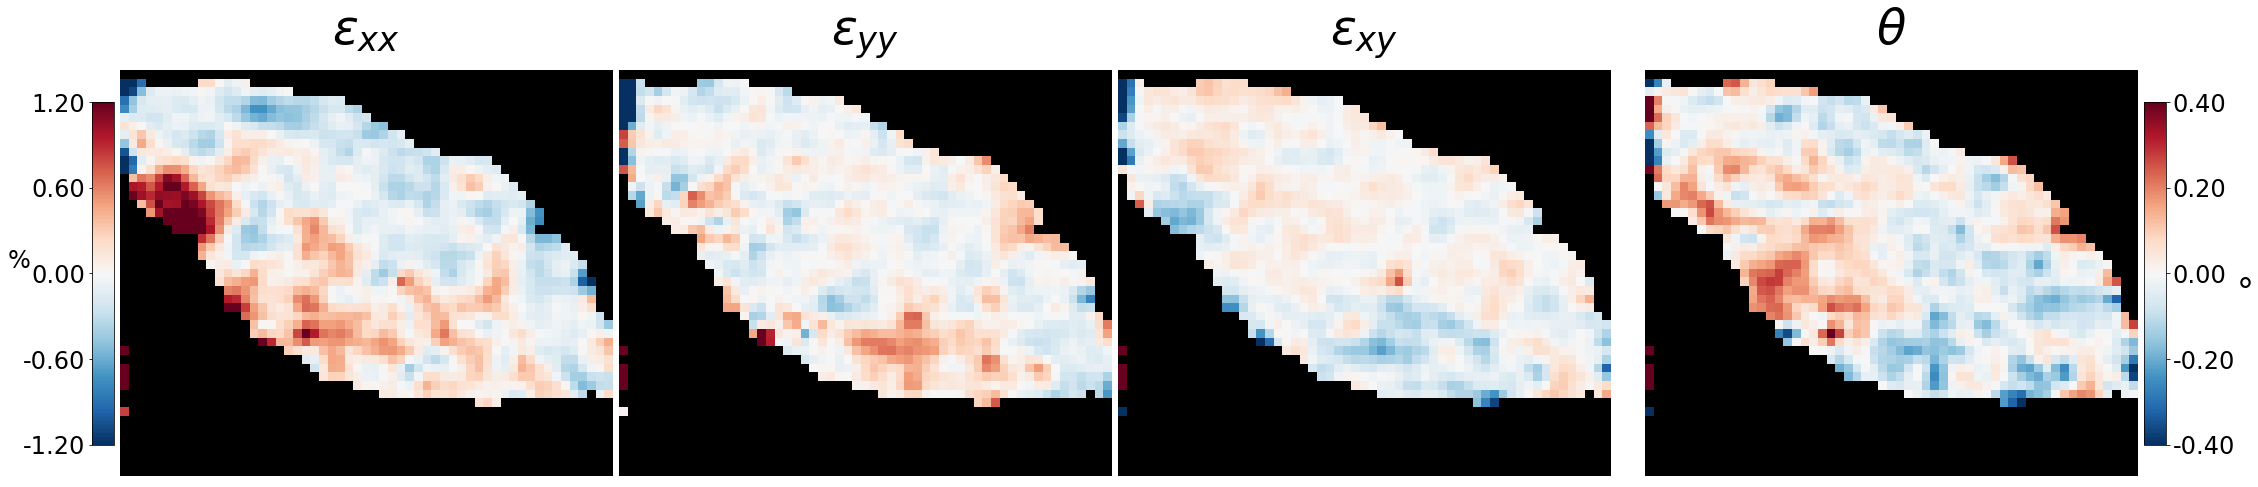

In [10]:
# Plot data
# Median filtering and gaussian smoothing
# Horizontal layout
# Shared colorbar, on sides

sigma = .8
titlesize=48
ticklabelsize=24

e_range = [-1.2,1.2] # In percentage
theta_range = [-.4,.4] # In degrees


# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_xx_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_xx'], medfilt(np.where(mask,strain_maps.data2D['e_xx'],0),kernel_size=3)),sigma),0)
e_yy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_yy'], medfilt(np.where(mask,strain_maps.data2D['e_yy'],0),kernel_size=3)),sigma),0)
e_xy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_xy'], medfilt(np.where(mask,strain_maps.data2D['e_xy'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

e_xx_ave = np.average(e_xx_smoothed[mask])
e_yy_ave = np.average(e_yy_smoothed[mask])
e_xy_ave = np.average(e_xy_smoothed[mask])
theta_ave = np.average(theta_smoothed[mask])

    
### Plot ###
fig = plt.figure(figsize=(32,10))
           
gs = gridspec.GridSpec(3, 15, width_ratios=[1,1,20,1,1,20,1,1,20,1,1,1,20,1,1], height_ratios=[1,5, 1])
gs.update(left=0.05, right=0.95, wspace=0.05)
ax1 = plt.subplot(gs[:,1:4])
ax2 = plt.subplot(gs[:,4:7])
ax3 = plt.subplot(gs[:,7:10,])
ax4 = plt.subplot(gs[:,11:14])

cbax1 = plt.subplot(gs[1,0])
cbax4 = plt.subplot(gs[1,14])
    
cax1 = ax1.matshow(e_xx_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
cax2 = ax2.matshow(e_yy_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
cax3 = ax3.matshow(e_xy_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
cax4 = ax4.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

# Black overlay
ax1.matshow(plot_mask,cmap='gray')
ax2.matshow(plot_mask,cmap='gray')
ax3.matshow(plot_mask,cmap='gray')
ax4.matshow(plot_mask,cmap='gray')
    
# Colorbars

cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,5,endpoint=True), orientation='vertical')
cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True), orientation='vertical')

cb1.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],5,endpoint=True)],size=ticklabelsize)
cb4.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax1.set_ylabel("%", size=ticklabelsize, rotation=0)
cbax4.set_ylabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

cbax1.yaxis.set_ticks_position('left')
cbax1.yaxis.set_label_position('left')

ax1.set_title(r'$\epsilon_{xx}$',size=titlesize)
ax2.set_title(r'$\epsilon_{yy}$',size=titlesize)
ax3.set_title(r'$\epsilon_{xy}$',size=titlesize)
ax4.set_title(r'$\theta$',size=titlesize)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.show()

### Rotate coordinates

To rotate the coordinate system, we apply a rotation $R$ to the strain matrix $\epsilon$.  Denoting the rotated matrix by $\epsilon'$, this is accomplished through the transformation $\epsilon' = R\epsilon R^T$, where $T$ indicates the transpose.  Thus if we take

\begin{equation}
R
=
\begin{pmatrix}
\cos\theta   &   -\sin\theta   \\
\sin\theta   &   \cos\theta
\end{pmatrix}
\end{equation}

and the unrotated strain matrix is

\begin{equation}
\epsilon
=
\begin{pmatrix}
\epsilon_{xx}   &   \epsilon_{xy}   \\
\epsilon_{xy}   &   \epsilon_{yy}
\end{pmatrix}
\end{equation}

Then direct computation gives

\begin{equation}
\epsilon'
=
\begin{pmatrix}
\cos^2\theta\epsilon_{xx} - 2\cos\theta\sin\theta\epsilon_{xy} + \sin^2\theta\epsilon_{yy}   &   \cos\theta\sin\theta(\epsilon_{xx} - \epsilon_{yy}) + (\cos^2\theta - \sin^2\theta)\epsilon_{xy}   \\
\cos\theta\sin\theta(\epsilon_{xx} - \epsilon_{yy}) + (\cos^2\theta - \sin^2\theta)\epsilon_{xy}   &   \sin^2\theta\epsilon_{xx} + 2\cos\theta\sin\theta\epsilon_{xy} + \cos^2\theta\epsilon_{yy}
\end{pmatrix}
\end{equation}

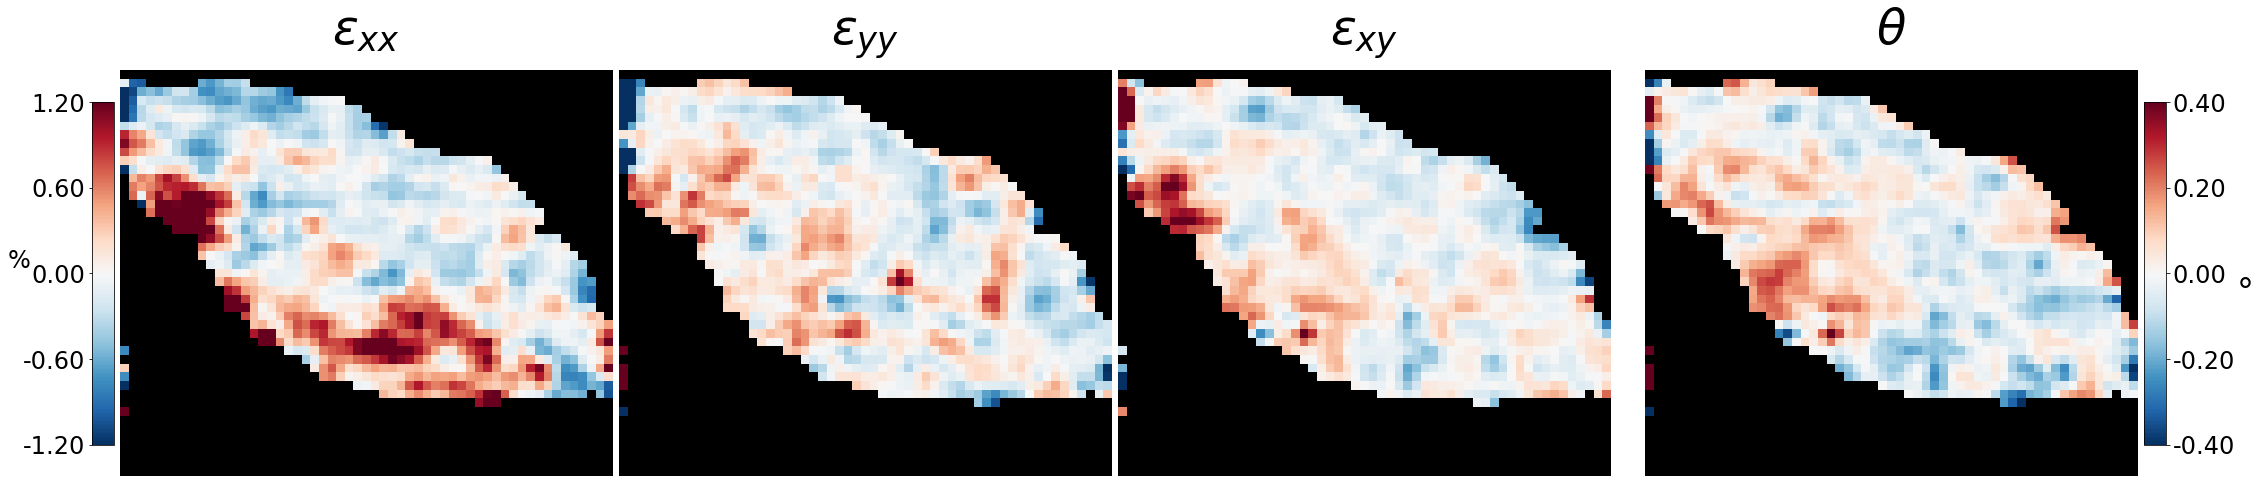

In [11]:
# Rotate coordinate system and plot
# Median filtering and gaussian smoothing
# Horizontal layout

rotation = 30 # in degrees
sigma = .8
titlesize=48
ticklabelsize=24

e_range = [-1.2,1.2] # In percentage
theta_range = [-.4,.4] # In degrees

# Rotate data
costheta = np.cos(rotation*np.pi/180.)
sintheta = np.cos(rotation*np.pi/180.)
e_xx_rotated = np.empty_like(strain_maps.data2D['e_xx'])
e_yy_rotated = np.empty_like(strain_maps.data2D['e_yy'])
e_xy_rotated = np.empty_like(strain_maps.data2D['e_xy'])
for Rx in range(strain_maps.R_Nx):
    for Ry in range(strain_maps.R_Ny):
        e_xx_rotated[Rx,Ry] = costheta**2*strain_maps.data2D['e_xx'][Rx,Ry] - 2*costheta*sintheta*strain_maps.data2D['e_xy'][Rx,Ry] + sintheta**2*strain_maps.data2D['e_yy'][Rx,Ry]
        e_yy_rotated[Rx,Ry] = sintheta**2*strain_maps.data2D['e_xx'][Rx,Ry] + 2*costheta*sintheta*strain_maps.data2D['e_xy'][Rx,Ry] + costheta**2*strain_maps.data2D['e_yy'][Rx,Ry]
        e_xy_rotated[Rx,Ry] = costheta*sintheta*(strain_maps.data2D['e_xx'][Rx,Ry]-strain_maps.data2D['e_yy'][Rx,Ry]) + (costheta**2-sintheta**2)*strain_maps.data2D['e_xy'][Rx,Ry]

# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_xx_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_xx_rotated, medfilt(np.where(mask,strain_maps.data2D['e_xx'],0),kernel_size=3)),sigma),0)
e_yy_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_yy_rotated, medfilt(np.where(mask,strain_maps.data2D['e_yy'],0),kernel_size=3)),sigma),0)
e_xy_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_xy_rotated, medfilt(np.where(mask,strain_maps.data2D['e_xy'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

e_xx_ave = np.average(e_xx_smoothed[mask])
e_yy_ave = np.average(e_yy_smoothed[mask])
e_xy_ave = np.average(e_xy_smoothed[mask])
theta_ave = np.average(theta_smoothed[mask])

    
### Plot ###
fig = plt.figure(figsize=(32,10))
           
gs = gridspec.GridSpec(3, 15, width_ratios=[1,1,20,1,1,20,1,1,20,1,1,1,20,1,1], height_ratios=[1,5, 1])
gs.update(left=0.05, right=0.95, wspace=0.05)
ax1 = plt.subplot(gs[:,1:4])
ax2 = plt.subplot(gs[:,4:7])
ax3 = plt.subplot(gs[:,7:10,])
ax4 = plt.subplot(gs[:,11:14])

cbax1 = plt.subplot(gs[1,0])
cbax4 = plt.subplot(gs[1,14])
    
cax1 = ax1.matshow(e_xx_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
cax2 = ax2.matshow(e_yy_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
cax3 = ax3.matshow(e_xy_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
cax4 = ax4.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

# Black overlay
ax1.matshow(plot_mask,cmap='gray')
ax2.matshow(plot_mask,cmap='gray')
ax3.matshow(plot_mask,cmap='gray')
ax4.matshow(plot_mask,cmap='gray')
    
# Colorbars

cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,5,endpoint=True), orientation='vertical')
cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True), orientation='vertical')

cb1.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],5,endpoint=True)],size=ticklabelsize)
cb4.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax1.set_ylabel("%", size=ticklabelsize, rotation=0)
cbax4.set_ylabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

cbax1.yaxis.set_ticks_position('left')
cbax1.yaxis.set_label_position('left')

ax1.set_title(r'$\epsilon_{xx}$',size=titlesize)
ax2.set_title(r'$\epsilon_{yy}$',size=titlesize)
ax3.set_title(r'$\epsilon_{xy}$',size=titlesize)
ax4.set_title(r'$\theta$',size=titlesize)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.show()

0 degrees


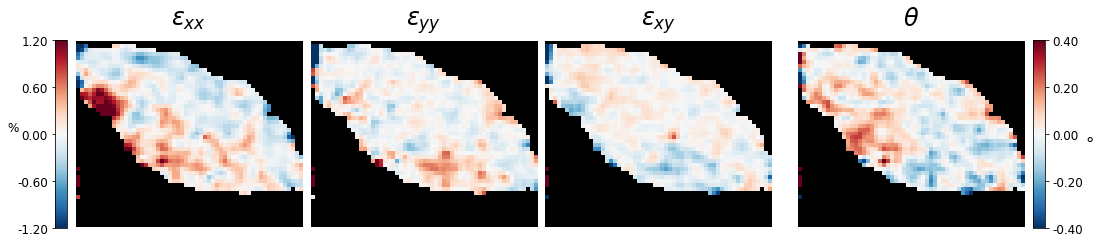

10 degrees


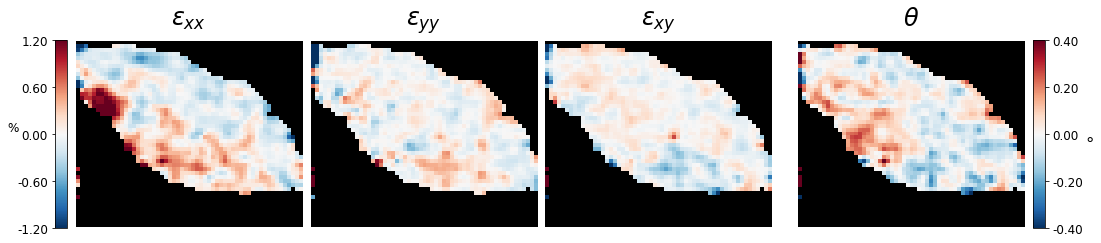

20 degrees


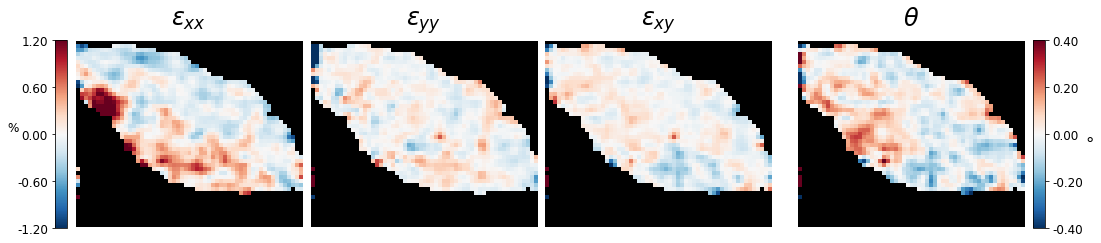

30 degrees


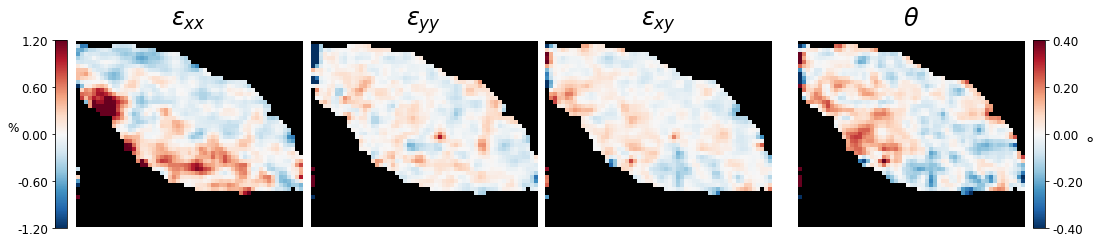

40 degrees


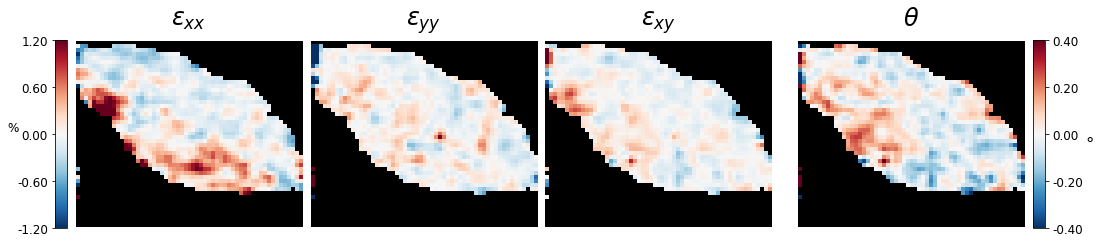

50 degrees


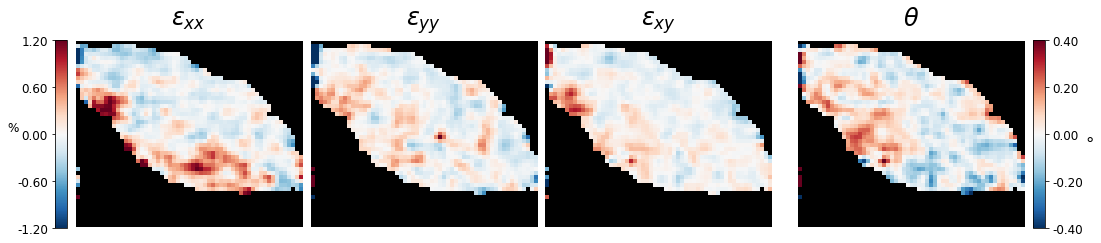

60 degrees


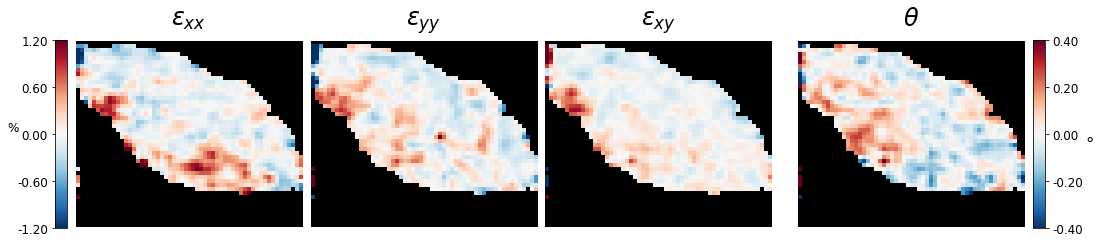

70 degrees


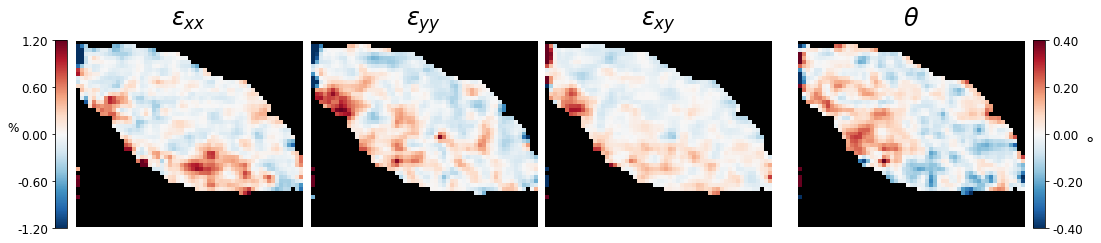

80 degrees


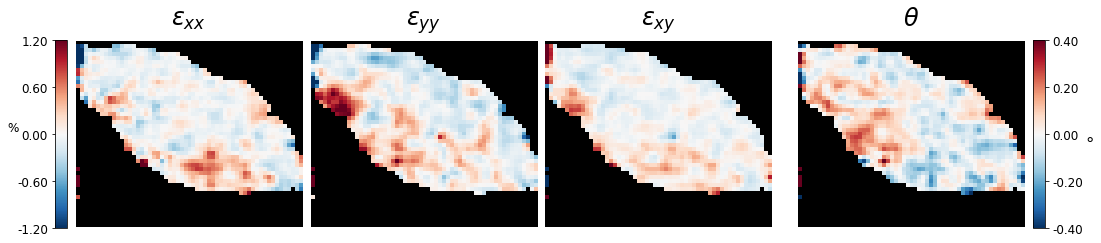

90 degrees


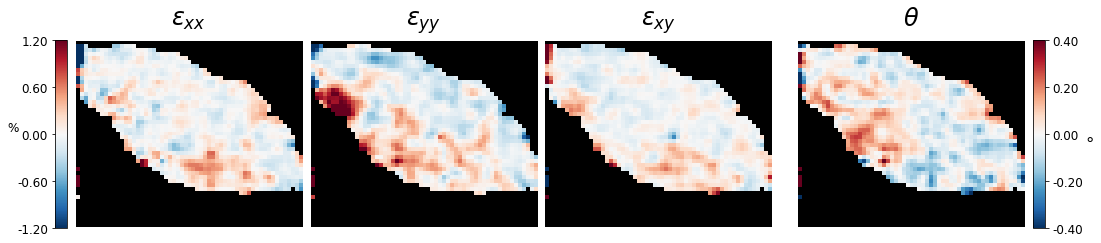

In [12]:
# Rotate coordinate system - multiple rotations
# Median filtering and gaussian smoothing
# Horizontal layout

rotations = [0,10,20,30,40,50,60,70,80,90] # in degrees
sigma = .8
titlesize=24
ticklabelsize=12

e_range = [-1.2,1.2] # In percentage
theta_range = [-.4,.4] # In degrees


for rotation in rotations:
    print("{} degrees".format(rotation))
    
    # Rotate data
    costheta = np.cos(rotation*np.pi/180.)
    sintheta = np.sin(rotation*np.pi/180.)
    e_xx_rotated = np.empty_like(strain_maps.data2D['e_xx'])
    e_yy_rotated = np.empty_like(strain_maps.data2D['e_yy'])
    e_xy_rotated = np.empty_like(strain_maps.data2D['e_xy'])
    for Rx in range(strain_maps.R_Nx):
        for Ry in range(strain_maps.R_Ny):
            e_xx_rotated[Rx,Ry] = costheta**2*strain_maps.data2D['e_xx'][Rx,Ry] - 2*costheta*sintheta*strain_maps.data2D['e_xy'][Rx,Ry] + sintheta**2*strain_maps.data2D['e_yy'][Rx,Ry]
            e_yy_rotated[Rx,Ry] = sintheta**2*strain_maps.data2D['e_xx'][Rx,Ry] + 2*costheta*sintheta*strain_maps.data2D['e_xy'][Rx,Ry] + costheta**2*strain_maps.data2D['e_yy'][Rx,Ry]
            e_xy_rotated[Rx,Ry] = costheta*sintheta*(strain_maps.data2D['e_xx'][Rx,Ry]-strain_maps.data2D['e_yy'][Rx,Ry]) + (costheta**2-sintheta**2)*strain_maps.data2D['e_xy'][Rx,Ry]

    # Get smoothed image, mask, and colorscale ranges
    plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

    e_xx_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_xx_rotated, medfilt(np.where(mask,strain_maps.data2D['e_xx'],0),kernel_size=3)),sigma),0)
    e_yy_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_yy_rotated, medfilt(np.where(mask,strain_maps.data2D['e_yy'],0),kernel_size=3)),sigma),0)
    e_xy_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_xy_rotated, medfilt(np.where(mask,strain_maps.data2D['e_xy'],0),kernel_size=3)),sigma),0)
    theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

    e_xx_ave = np.average(e_xx_smoothed[mask])
    e_yy_ave = np.average(e_yy_smoothed[mask])
    e_xy_ave = np.average(e_xy_smoothed[mask])
    theta_ave = np.average(theta_smoothed[mask])


    ### Plot ###
    fig = plt.figure(figsize=(32,5))

    gs = gridspec.GridSpec(3, 15, width_ratios=[1.3,1,20,1,1,20,1,1,20,1,1,1,20,1,1.3], height_ratios=[1,5, 1])
    gs.update(left=0.05, right=0.48, wspace=0.05)
    ax1 = plt.subplot(gs[:,1:4])
    ax2 = plt.subplot(gs[:,4:7])
    ax3 = plt.subplot(gs[:,7:10,])
    ax4 = plt.subplot(gs[:,11:14])

    cbax1 = plt.subplot(gs[1,0])
    cbax4 = plt.subplot(gs[1,14])

    gs.update(wspace=0.15, hspace=0.05)

    cax1 = ax1.matshow(e_xx_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
    cax2 = ax2.matshow(e_yy_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
    cax3 = ax3.matshow(e_xy_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
    cax4 = ax4.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

    # Black overlay
    ax1.matshow(plot_mask,cmap='gray')
    ax2.matshow(plot_mask,cmap='gray')
    ax3.matshow(plot_mask,cmap='gray')
    ax4.matshow(plot_mask,cmap='gray')

    # Colorbars

    cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,5,endpoint=True), orientation='vertical')
    cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True), orientation='vertical')

    cb1.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],5,endpoint=True)],size=ticklabelsize)
    cb4.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

    cbax1.set_ylabel("%", size=ticklabelsize, rotation=0)
    cbax4.set_ylabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

    cbax1.yaxis.set_ticks_position('left')
    cbax1.yaxis.set_label_position('left')

    ax1.set_title(r'$\epsilon_{xx}$',size=titlesize)
    ax2.set_title(r'$\epsilon_{yy}$',size=titlesize)
    ax3.set_title(r'$\epsilon_{xy}$',size=titlesize)
    ax4.set_title(r'$\theta$',size=titlesize)

    ax1.axis('off')
    ax2.axis('off')
    ax3.axis('off')
    ax4.axis('off')

    plt.show()

### Save figures

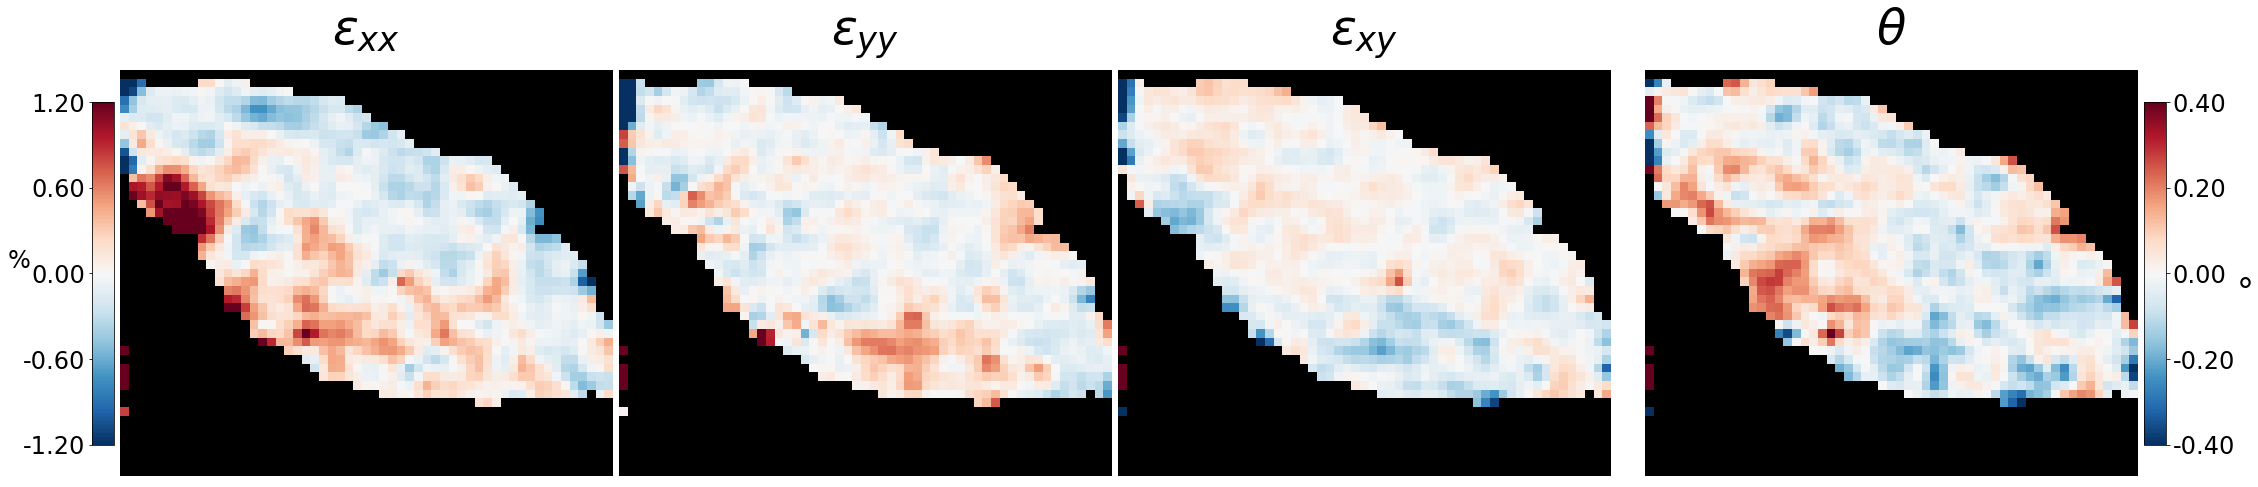

In [13]:
# Save

savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/strain_maps_horizontal_share_cbar_2.pdf"

# Plot data
# Median filtering and gaussian smoothing
# Horizontal layout
# Shared colorbar, on sides

sigma = .8
titlesize=48
ticklabelsize=24

e_range = [-1.2,1.2] # In percentage
theta_range = [-.4,.4] # In degrees


# Get smoothed image, mask, and colorscale ranges
plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

e_xx_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_xx'], medfilt(np.where(mask,strain_maps.data2D['e_xx'],0),kernel_size=3)),sigma),0)
e_yy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_yy'], medfilt(np.where(mask,strain_maps.data2D['e_yy'],0),kernel_size=3)),sigma),0)
e_xy_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['e_xy'], medfilt(np.where(mask,strain_maps.data2D['e_xy'],0),kernel_size=3)),sigma),0)
theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

e_xx_ave = np.average(e_xx_smoothed[mask])
e_yy_ave = np.average(e_yy_smoothed[mask])
e_xy_ave = np.average(e_xy_smoothed[mask])
theta_ave = np.average(theta_smoothed[mask])

    
### Plot ###
fig = plt.figure(figsize=(32,10))
           
gs = gridspec.GridSpec(3, 15, width_ratios=[1,1,20,1,1,20,1,1,20,1,1,1,20,1,1], height_ratios=[1,5, 1])
gs.update(left=0.05, right=0.95, wspace=0.05)
ax1 = plt.subplot(gs[:,1:4])
ax2 = plt.subplot(gs[:,4:7])
ax3 = plt.subplot(gs[:,7:10,])
ax4 = plt.subplot(gs[:,11:14])

cbax1 = plt.subplot(gs[1,0])
cbax4 = plt.subplot(gs[1,14])
    
cax1 = ax1.matshow(e_xx_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
cax2 = ax2.matshow(e_yy_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
cax3 = ax3.matshow(e_xy_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
cax4 = ax4.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

# Black overlay
ax1.matshow(plot_mask,cmap='gray')
ax2.matshow(plot_mask,cmap='gray')
ax3.matshow(plot_mask,cmap='gray')
ax4.matshow(plot_mask,cmap='gray')
    
# Colorbars

cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,5,endpoint=True), orientation='vertical')
cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,5,endpoint=True), orientation='vertical')

cb1.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],5,endpoint=True)],size=ticklabelsize)
cb4.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],5,endpoint=True)],size=ticklabelsize)

cbax1.set_ylabel("%", size=ticklabelsize, rotation=0)
cbax4.set_ylabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

cbax1.yaxis.set_ticks_position('left')
cbax1.yaxis.set_label_position('left')

ax1.set_title(r'$\epsilon_{xx}$',size=titlesize)
ax2.set_title(r'$\epsilon_{yy}$',size=titlesize)
ax3.set_title(r'$\epsilon_{xy}$',size=titlesize)
ax4.set_title(r'$\theta$',size=titlesize)

ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
ax4.axis('off')

plt.savefig(savepath)
plt.show()

### Multiple rotations in one plot

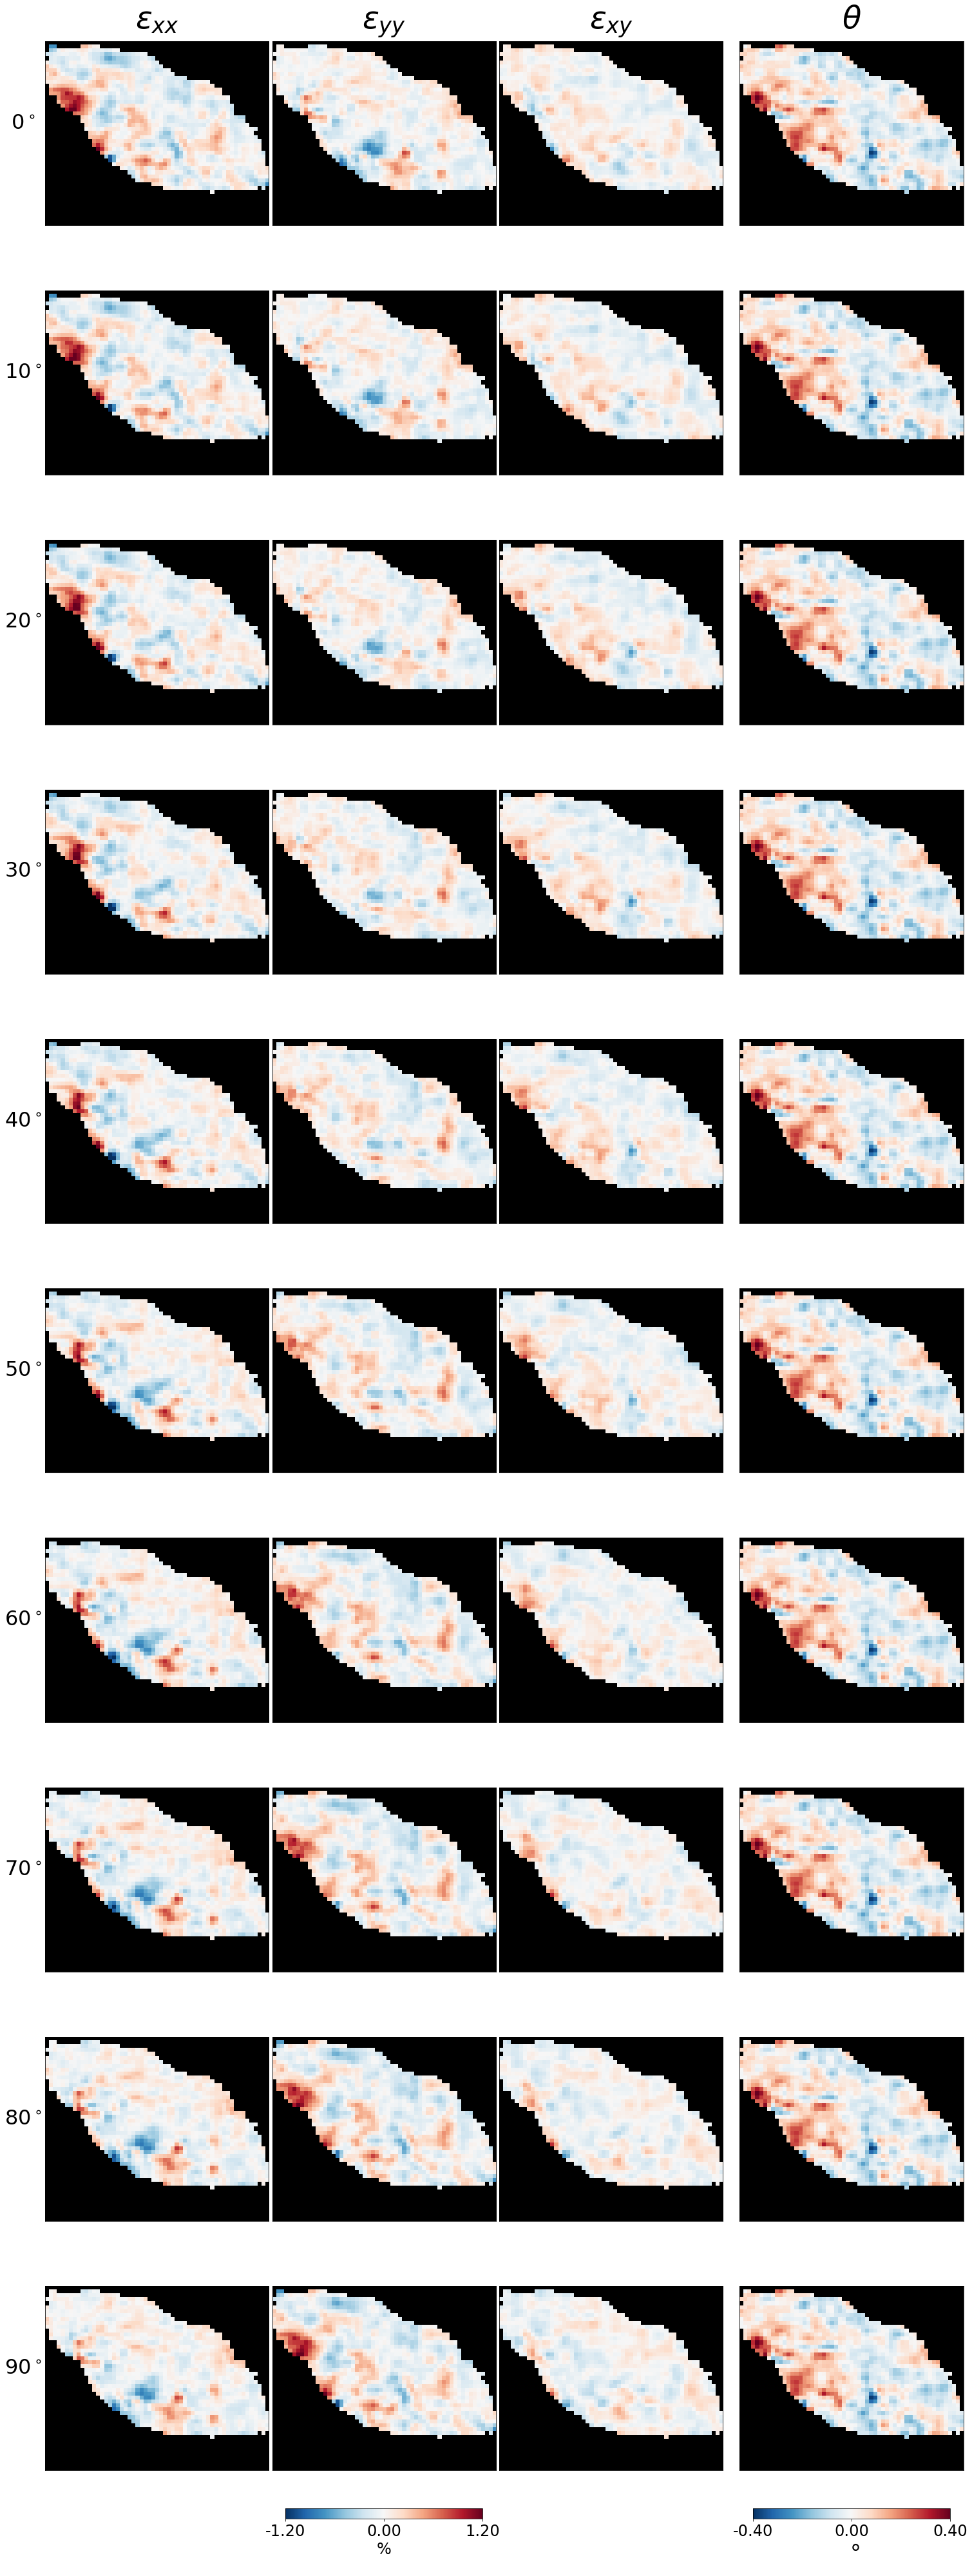

In [16]:
# Plot data
# Median filtering and gaussian smoothing
# Large plot with vertical layout
# Shared colorbar, on bottom

savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/multiple_rotations_vertical.pdf"

rotations = [0,10,20,30,40,50,60,70,80,90] # in degrees
sigma = .8
titlesize=48
rotationlabelsize=32
ticklabelsize=24

e_range = [-1.2,1.2] # In percentage
theta_range = [-.4,.4] # In degrees



# Figure
fig = plt.figure(figsize=(22,6*len(rotations)))
gs = gridspec.GridSpec(len(rotations)+1, 13, width_ratios=[1,20,1,1,20,1,1,20,1,1,1,20,1], height_ratios=[24]*len(rotations)+[1])
gs.update(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.05, hspace=0.05)

for i in range(len(rotations)):
    rotation = rotations[i]

     # Rotate data
    costheta = np.cos(rotation*np.pi/180.)
    sintheta = np.sin(rotation*np.pi/180.)
    e_xx_rotated = np.empty_like(strain_maps.data2D['e_xx'])
    e_yy_rotated = np.empty_like(strain_maps.data2D['e_yy'])
    e_xy_rotated = np.empty_like(strain_maps.data2D['e_xy'])
    for Rx in range(strain_maps.R_Nx):
        for Ry in range(strain_maps.R_Ny):
            e_xx_rotated[Rx,Ry] = costheta**2*strain_maps.data2D['e_xx'][Rx,Ry] - 2*costheta*sintheta*strain_maps.data2D['e_xy'][Rx,Ry] + sintheta**2*strain_maps.data2D['e_yy'][Rx,Ry]
            e_yy_rotated[Rx,Ry] = sintheta**2*strain_maps.data2D['e_xx'][Rx,Ry] + 2*costheta*sintheta*strain_maps.data2D['e_xy'][Rx,Ry] + costheta**2*strain_maps.data2D['e_yy'][Rx,Ry]
            e_xy_rotated[Rx,Ry] = costheta*sintheta*(strain_maps.data2D['e_xx'][Rx,Ry]-strain_maps.data2D['e_yy'][Rx,Ry]) + (costheta**2-sintheta**2)*strain_maps.data2D['e_xy'][Rx,Ry]
    
    # Get smoothed image, mask, and colorscale ranges
    plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

    e_xx_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_xx_rotated, medfilt(np.where(mask,strain_maps.data2D['e_xx'],0),kernel_size=3)),sigma),0)
    e_yy_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_yy_rotated, medfilt(np.where(mask,strain_maps.data2D['e_yy'],0),kernel_size=3)),sigma),0)
    e_xy_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_xy_rotated, medfilt(np.where(mask,strain_maps.data2D['e_xy'],0),kernel_size=3)),sigma),0)
    theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

    e_xx_ave = np.average(e_xx_smoothed[mask])
    e_yy_ave = np.average(e_yy_smoothed[mask])
    e_xy_ave = np.average(e_xy_smoothed[mask])
    theta_ave = np.average(theta_smoothed[mask])


    ### Plot ###

    ax1 = plt.subplot(gs[i,0:3])
    ax2 = plt.subplot(gs[i,3:6])
    ax3 = plt.subplot(gs[i,6:9,])
    ax4 = plt.subplot(gs[i,10:13])

    cax1 = ax1.matshow(e_xx_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
    cax2 = ax2.matshow(e_yy_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
    cax3 = ax3.matshow(e_xy_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
    cax4 = ax4.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

    # Black overlay
    ax1.matshow(plot_mask,cmap='gray')
    ax2.matshow(plot_mask,cmap='gray')
    ax3.matshow(plot_mask,cmap='gray')
    ax4.matshow(plot_mask,cmap='gray')

    # Row labels
    ax1.set_ylabel(r"{}$^\circ$      ".format(rotation), size=rotationlabelsize, rotation=0)
    
    # Column labels
    if i==0:
        ax1.set_title(r'$\epsilon_{xx}$',size=titlesize)
        ax2.set_title(r'$\epsilon_{yy}$',size=titlesize)
        ax3.set_title(r'$\epsilon_{xy}$',size=titlesize)
        ax4.set_title(r'$\theta$',size=titlesize)

    # Colorbars
    if i==len(rotations)-1:
        cbax1 = plt.subplot(gs[i+1,1])
        cbax2 = plt.subplot(gs[i+1,4])
        cbax3 = plt.subplot(gs[i+1,7,])
        cbax4 = plt.subplot(gs[i+1,11])

        cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,3,endpoint=True), orientation='horizontal')
        cb2 = plt.colorbar(cax2, cax=cbax2, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,3,endpoint=True), orientation='horizontal')
        cb3 = plt.colorbar(cax3, cax=cbax3, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,3,endpoint=True), orientation='horizontal')
        cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,3,endpoint=True), orientation='horizontal')

        cb1.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],3,endpoint=True)],size=ticklabelsize)
        cb2.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],3,endpoint=True)],size=ticklabelsize)
        cb3.ax.set_xticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],3,endpoint=True)],size=ticklabelsize)
        cb4.ax.set_xticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],3,endpoint=True)],size=ticklabelsize)

        cbax1.set_xlabel("%", size=ticklabelsize, rotation=0)
        cbax2.set_xlabel("%", size=ticklabelsize, rotation=0)
        cbax3.set_xlabel("%", size=ticklabelsize, rotation=0)
        cbax4.set_xlabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

        cb1.remove()
        cb3.remove()
    
    ax1.xaxis.set_ticks([]) 
    ax1.yaxis.set_ticks([]) 
    ax2.xaxis.set_ticks([]) 
    ax2.yaxis.set_ticks([]) 
    ax3.xaxis.set_ticks([]) 
    ax3.yaxis.set_ticks([]) 
    ax4.xaxis.set_ticks([]) 
    ax4.yaxis.set_ticks([]) 

plt.savefig(savepath)
plt.show()

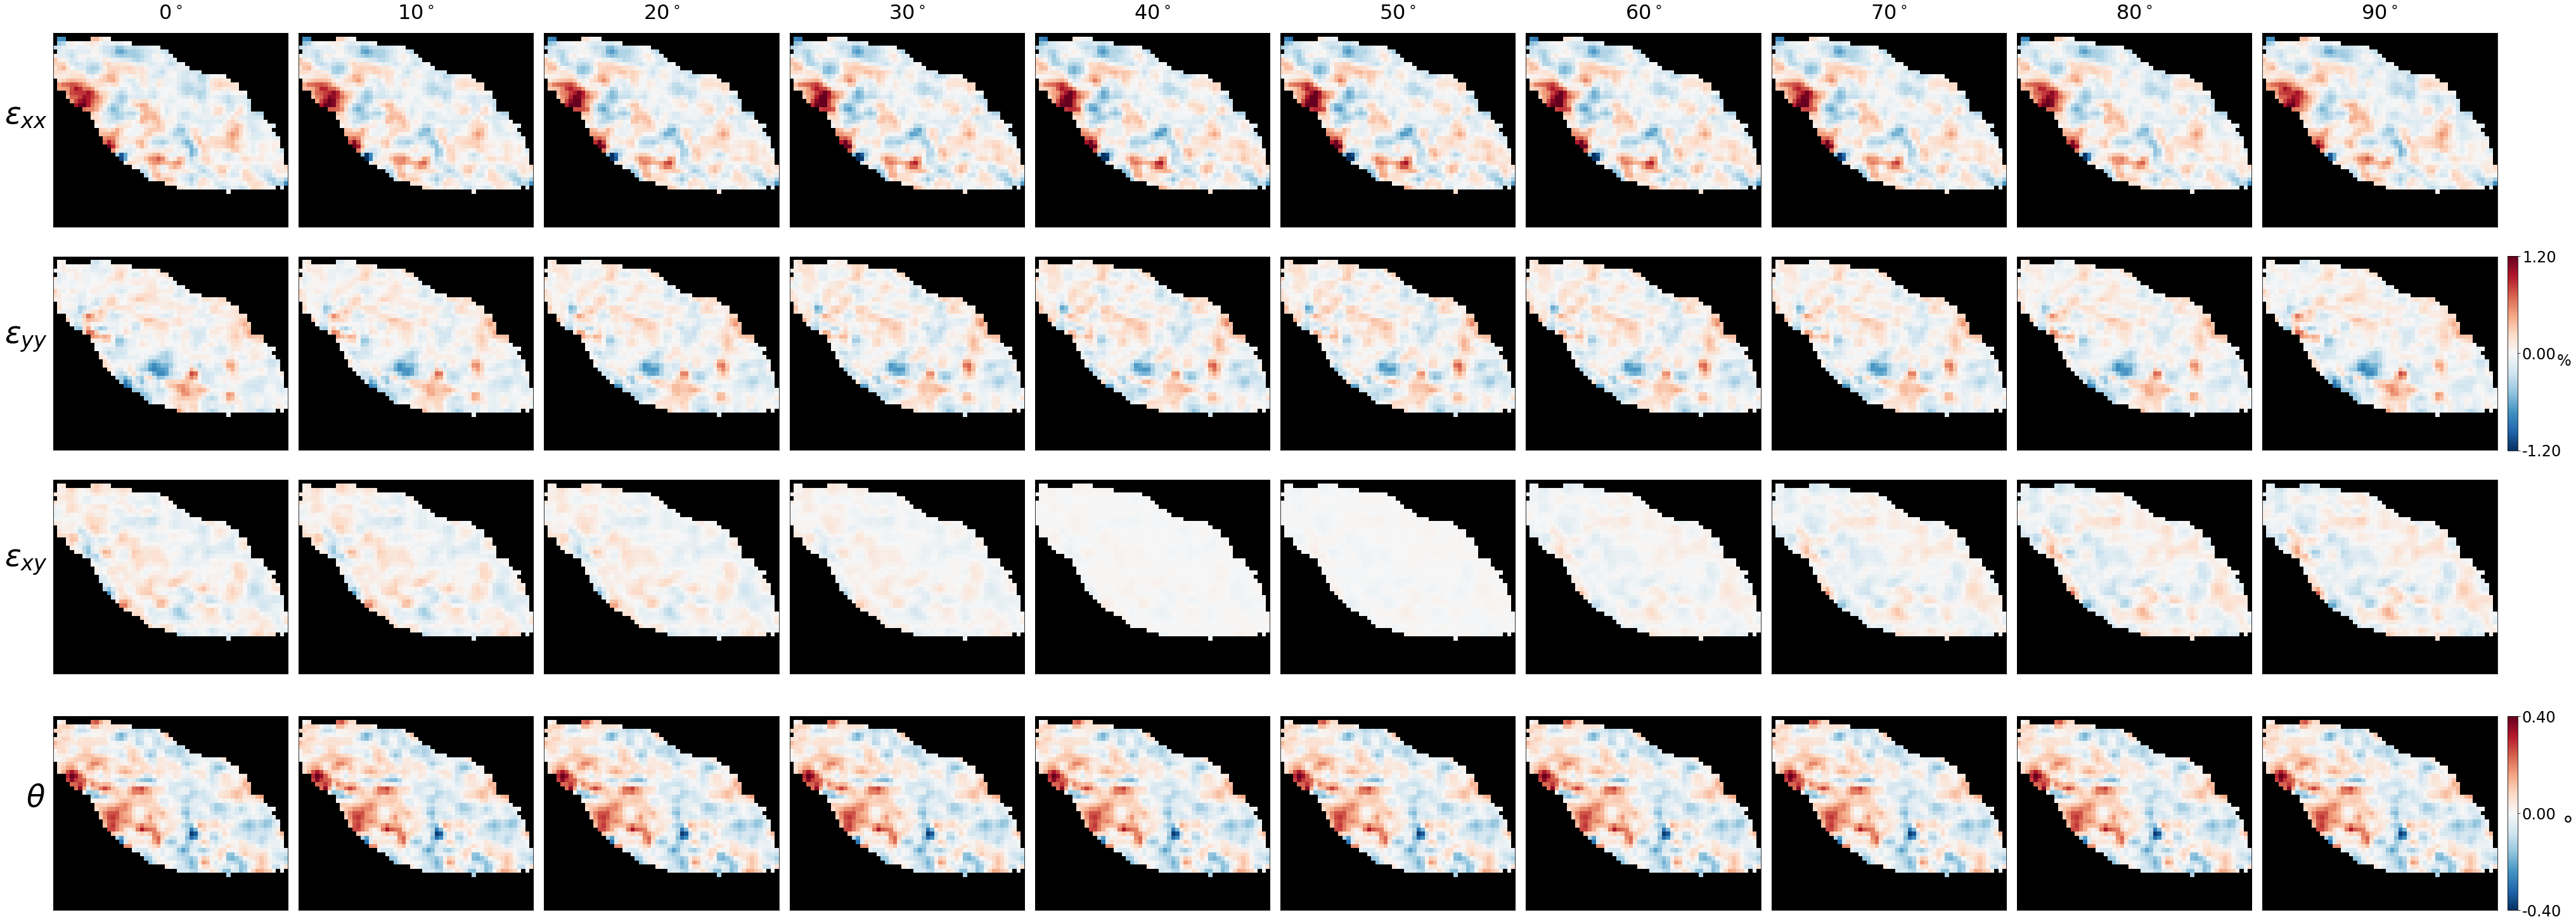

In [17]:
# Plot data
# Median filtering and gaussian smoothing
# Large plot with horizontal layout
# Shared colorbar, on bottom

savepath = "/home/ben/Data/20180905_FePO4_unlithiated/processing/multiple_rotations_horizontal.pdf"

rotations = [0,10,20,30,40,50,60,70,80,90] # in degrees
sigma = .8
titlesize=48
rotationlabelsize=32
ticklabelsize=24

e_range = [-1.2,1.2] # In percentage
theta_range = [-.4,.4] # In degrees



# Figure
fig = plt.figure(figsize=(6*len(rotations),22))
gs = gridspec.GridSpec(13, len(rotations)+1, height_ratios=[1,20,1,1,20,1,1,20,1,1,1,20,1], width_ratios=[24]*len(rotations)+[1])
gs.update(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.05, hspace=0.05)

for i in range(len(rotations)):
    rotation = rotations[i]

     # Rotate data
    costheta = np.cos(rotation*np.pi/180.)
    sintheta = np.sin(rotation*np.pi/180.)
    e_xx_rotated = np.empty_like(strain_maps.data2D['e_xx'])
    e_yy_rotated = np.empty_like(strain_maps.data2D['e_yy'])
    e_xy_rotated = np.empty_like(strain_maps.data2D['e_xy'])
    for Rx in range(strain_maps.R_Nx):
        for Ry in range(strain_maps.R_Ny):
            e_xx_rotated[Rx,Ry] = costheta**2*strain_maps.data2D['e_xx'][Rx,Ry] - 2*costheta*sintheta*strain_maps.data2D['e_xy'][Rx,Ry] + sintheta**2*strain_maps.data2D['e_xx'][Rx,Ry]
            e_yy_rotated[Rx,Ry] = sintheta**2*strain_maps.data2D['e_yy'][Rx,Ry] + 2*costheta*sintheta*strain_maps.data2D['e_xy'][Rx,Ry] + costheta**2*strain_maps.data2D['e_yy'][Rx,Ry]
            e_xy_rotated[Rx,Ry] = costheta*sintheta*(strain_maps.data2D['e_yy'][Rx,Ry]-strain_maps.data2D['e_yy'][Rx,Ry]) + (costheta**2-sintheta**2)*strain_maps.data2D['e_xy'][Rx,Ry]
    
    # Get smoothed image, mask, and colorscale ranges
    plot_mask = np.ma.masked_where(mask, np.ones_like(mask))

    e_xx_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_xx_rotated, medfilt(np.where(mask,strain_maps.data2D['e_xx'],0),kernel_size=3)),sigma),0)
    e_yy_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_yy_rotated, medfilt(np.where(mask,strain_maps.data2D['e_yy'],0),kernel_size=3)),sigma),0)
    e_xy_smoothed = np.where(mask,gaussian_filter(np.where(mask, e_xy_rotated, medfilt(np.where(mask,strain_maps.data2D['e_xy'],0),kernel_size=3)),sigma),0)
    theta_smoothed = np.where(mask,gaussian_filter(np.where(mask, strain_maps.data2D['theta'], medfilt(np.where(mask,strain_maps.data2D['theta'],0),kernel_size=3)),sigma),0)

    e_xx_ave = np.average(e_xx_smoothed[mask])
    e_yy_ave = np.average(e_yy_smoothed[mask])
    e_xy_ave = np.average(e_xy_smoothed[mask])
    theta_ave = np.average(theta_smoothed[mask])


    ### Plot ###

    ax1 = plt.subplot(gs[0:3,i])
    ax2 = plt.subplot(gs[3:6,i])
    ax3 = plt.subplot(gs[6:9,i])
    ax4 = plt.subplot(gs[10:13,i])

    cax1 = ax1.matshow(e_xx_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
    cax2 = ax2.matshow(e_yy_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
    cax3 = ax3.matshow(e_xy_smoothed,vmin=e_range[0]/100., vmax=e_range[1]/100., cmap="RdBu_r")
    cax4 = ax4.matshow(theta_smoothed,vmin=theta_range[0]*np.pi/180., vmax=theta_range[1]*np.pi/180., cmap="RdBu_r")

    # Black overlay
    ax1.matshow(plot_mask,cmap='gray')
    ax2.matshow(plot_mask,cmap='gray')
    ax3.matshow(plot_mask,cmap='gray')
    ax4.matshow(plot_mask,cmap='gray')

    # Row labels
    ax1.set_title(r"{}$^\circ$".format(rotation), size=rotationlabelsize)
        
    # Column labels
    if i==0:
        ax1.set_ylabel(r'$\epsilon_{xx}$      ',size=titlesize, rotation=0)
        ax2.set_ylabel(r'$\epsilon_{yy}$      ',size=titlesize, rotation=0)
        ax3.set_ylabel(r'$\epsilon_{xy}$      ',size=titlesize, rotation=0)
        ax4.set_ylabel(r'$\theta$    ',size=titlesize, rotation=0)

    # Colorbars
    if i==len(rotations)-1:
        cbax1 = plt.subplot(gs[1,i+1])
        cbax2 = plt.subplot(gs[4,i+1])
        cbax3 = plt.subplot(gs[7,i+1])
        cbax4 = plt.subplot(gs[11,i+1])

        cb1 = plt.colorbar(cax1, cax=cbax1, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,3,endpoint=True), orientation='vertical')
        cb2 = plt.colorbar(cax2, cax=cbax2, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,3,endpoint=True), orientation='vertical')
        cb3 = plt.colorbar(cax3, cax=cbax3, ticks=np.linspace(e_range[0]/100.,e_range[1]/100.,3,endpoint=True), orientation='vertical')
        cb4 = plt.colorbar(cax4, cax=cbax4, ticks=np.linspace(theta_range[0]*np.pi/180.,theta_range[1]*np.pi/180.,3,endpoint=True), orientation='vertical')

        cb1.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],3,endpoint=True)],size=ticklabelsize)
        cb2.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],3,endpoint=True)],size=ticklabelsize)
        cb3.ax.set_yticklabels(['{:.2f}'.format(val) for val in np.linspace(e_range[0],e_range[1],3,endpoint=True)],size=ticklabelsize)
        cb4.ax.set_yticklabels(['{:.2f}'.format(theta) for theta in np.linspace(theta_range[0],theta_range[1],3,endpoint=True)],size=ticklabelsize)

        cbax1.set_ylabel("%", size=ticklabelsize, rotation=0)
        cbax2.set_ylabel("%", size=ticklabelsize, rotation=0)
        cbax3.set_ylabel("%", size=ticklabelsize, rotation=0)
        cbax4.set_ylabel(r"$^\circ$", size=2*ticklabelsize, rotation=0)

        cb1.remove()
        cb3.remove()
    
    ax1.xaxis.set_ticks([]) 
    ax1.yaxis.set_ticks([]) 
    ax2.xaxis.set_ticks([]) 
    ax2.yaxis.set_ticks([]) 
    ax3.xaxis.set_ticks([]) 
    ax3.yaxis.set_ticks([]) 
    ax4.xaxis.set_ticks([]) 
    ax4.yaxis.set_ticks([]) 

plt.savefig(savepath)
plt.show()